In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import os
from collections import Counter
import pandas as pd
import numpy as np

In [2]:
class Evaluter(Callback):
    pass

In [3]:
class ClassifierDataGenerator:
    def __init__(self, data_x, data_y, batch_size, max_len, dic2num, class_num):
        self.data_x = data_x
        self.data_y = data_y
        self.batch_size = batch_size
        self.max_len = max_len
        self.dic2num = dic2num
        self.class_num = class_num
        self.steps = len(self.data_x) // self.batch_size
        if len(self.data_x) % self.batch_size != 0:
            self.steps += 1
            
    def __len__(self):
        return self.steps
    
    def __seq_padding__(self, X, padding=0):
        mx = max(map(len,X))
        return np.array([
            np.concatenate([x, [padding]*(mx-len(x))]) if mx>len(x) else x for x in X
        ])
    
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data_x)))
            np.random.shuffle(idxs)
            X, Y = [], []
            for i in idxs:
                x = self.data_x[i][:self.max_len]
                x = [self.dic2num[i] if i in self.dic2num else 0 for i in x]
                if len(x)<self.max_len:
                    x = np.concatenate([x, [0]*(self.max_len-len(x))])
                
                y = np.zeros((self.class_num))    
                y[self.data_y[i]] = 1
                
                X.append(x)
                Y.append(y)
                
                if len(X)==self.batch_size or i==idxs[-1]:
                    X = self.__seq_padding__(X)
                    Y = self.__seq_padding__(Y)
                    yield X, Y
                    [X, Y] = [],[]

In [4]:
class BaseModel:
    def __init__(self, train_X, train_y, batch_size, epochs, optimizer, learning_rate, metrics, loss, delete_feature_rate, test_size):
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.delete_feature_rate = delete_feature_rate
        self.train_X = train_X
        self.train_y = train_y
        self.class_num = len(Counter(self.train_y))
        self.test_size = test_size
        
        if len(train_X) != len(train_y):
            raise ValueError("Please check the length of train_X and train_y,Their length doesn't match.")
            
        if self.class_num<=1:
            raise ValueError("Only one label, please check again.")
        
        # 获取最大特征长度和字典
        content = "".join(self.train_X.reshape(-1))
        tmp = pd.Series(list(content)).value_counts()
        tmp = tmp[tmp>delete_feature_rate]
        self.dic2num = {key:value for value,key in enumerate(tmp.index)}
        self.num2dic = {value:key for value,key in enumerate(tmp.index)}
        self.max_feature = len(self.dic2num)
        self.samples = len(self.train_X)
        
    def _get_class_num(self):
        return self.class_num
    
    def _get_max_feature(self):
        return self.max_feature
    
    def _get_dic2num(self):
        return self.dic2num
    
    def _get_num2dic(self):
        return self.num2dic

In [17]:
class TextCNN(BaseModel):
    def __init__(
        self,
        train_X, 
        train_y,
        batch_size=32, 
        epochs=10, 
        optimizer="Adam", 
        learning_rate=1e-2, 
        metrics=["accuracy"], 
        loss="categorical_crossentropy",
        delete_feature_rate=1,
        model_name = "TextCNN",
        test_size = .3,
        **kwargs):
        super(TextCNN, self).__init__(
            train_X = train_X,
            train_y = train_y,
            batch_size=batch_size, 
            epochs=epochs, 
            optimizer=optimizer, 
            learning_rate=learning_rate, 
            metrics=metrics, 
            loss=loss,
            delete_feature_rate=delete_feature_rate,
            test_size=test_size
        )
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.delete_feature_rate = delete_feature_rate
        self.model_name = model_name
        self.train_X = train_X
        self.train_y = train_y
        
        # 如果用户要指定模型中的参数，则按照用户指定的参数设置，否则采用默认参数
        self.embedding_dims = kwargs.get("embedding_dims", 128)
        self.text_maxlen = kwargs.get("text_maxlen", 100)
        self.conv1d_filter_nums = kwargs.get("conv1d_filter_nums", 128)
        self.conv1d_kernel_size_list = kwargs.get("conv1d_kernel_size_list", [3,4,5])
        self.conv1d_activation = kwargs.get("conv1d_activation", "relu")
        self.dropout_rate = kwargs.get("dropout_rate", 0.5)
        self.dense_activation = kwargs.get("dense_activation", "softmax")
        self.random_state = kwargs.get("random_state", 1)
        
        self.model = self.textcnn(self.text_maxlen)

            
    def textcnn(self, input_shape):
        X_input = Input(input_shape)

        X = Embedding(self.max_feature, self.embedding_dims, input_length=self.text_maxlen)(X_input)

        convs = []

        for kernel_size in self.conv1d_kernel_size_list:
            c = Conv1D(self.conv1d_filter_nums, kernel_size, activation=self.conv1d_activation)(X)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)

        X = Concatenate()(convs)
        X = Flatten()(X)
        X = Dropout(self.dropout_rate)(X)

        X_output = Dense(self.class_num, activation=self.dense_activation)(X)

        model = Model(inputs=X_input, outputs=X_output, name=self.class_num)

        return model
                    
    def fit(self):
        train_X, val_X, train_y, val_y = train_test_split(self.train_X, self.train_y, test_size=self.test_size, random_state=self.random_state)
        train_generator = ClassifierDataGenerator(train_X, train_y, self.batch_size, self.text_maxlen, self.dic2num, self.class_num)
        val_generator = ClassifierDataGenerator(val_X, val_y, self.batch_size, self.text_maxlen, self.dic2num, self.class_num)
        print("define model...")
        model = self.textcnn((self.text_maxlen))
        print("compile model...")
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        print("fit model...")
        model.fit_generator(train_generator.__iter__(), steps_per_epoch=len(train_generator), 
                            epochs=self.epochs, validation_data=val_generator.__iter__(), validation_steps=len(val_generator))
        
    def predict(self):
        print(self._get_class_num())
    
    def plot_model(self):
        return plot_model(self.model, show_shapes=True)
    
    def summary(self):
        self.model.summary()

In [18]:
data = pd.read_csv("data/data_all.csv", index_col=0)
data_list = []
label_list = []
for index,text in data.iterrows():
    data_list.append(text["review"])
    label_list.append(text["label"])
    
data_array = np.array(data_list)
label_array = np.array(label_list)

In [23]:
textcnn = TextCNN(data_array, label_array, conv1d_kernel_size_list=[2,3,4,5,6,7])

In [24]:
textcnn.summary()

Model: "3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 128)     232576      input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 99, 128)      32896       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 98, 128)      49280       embedding_4[0][0]                
__________________________________________________________________________________________________

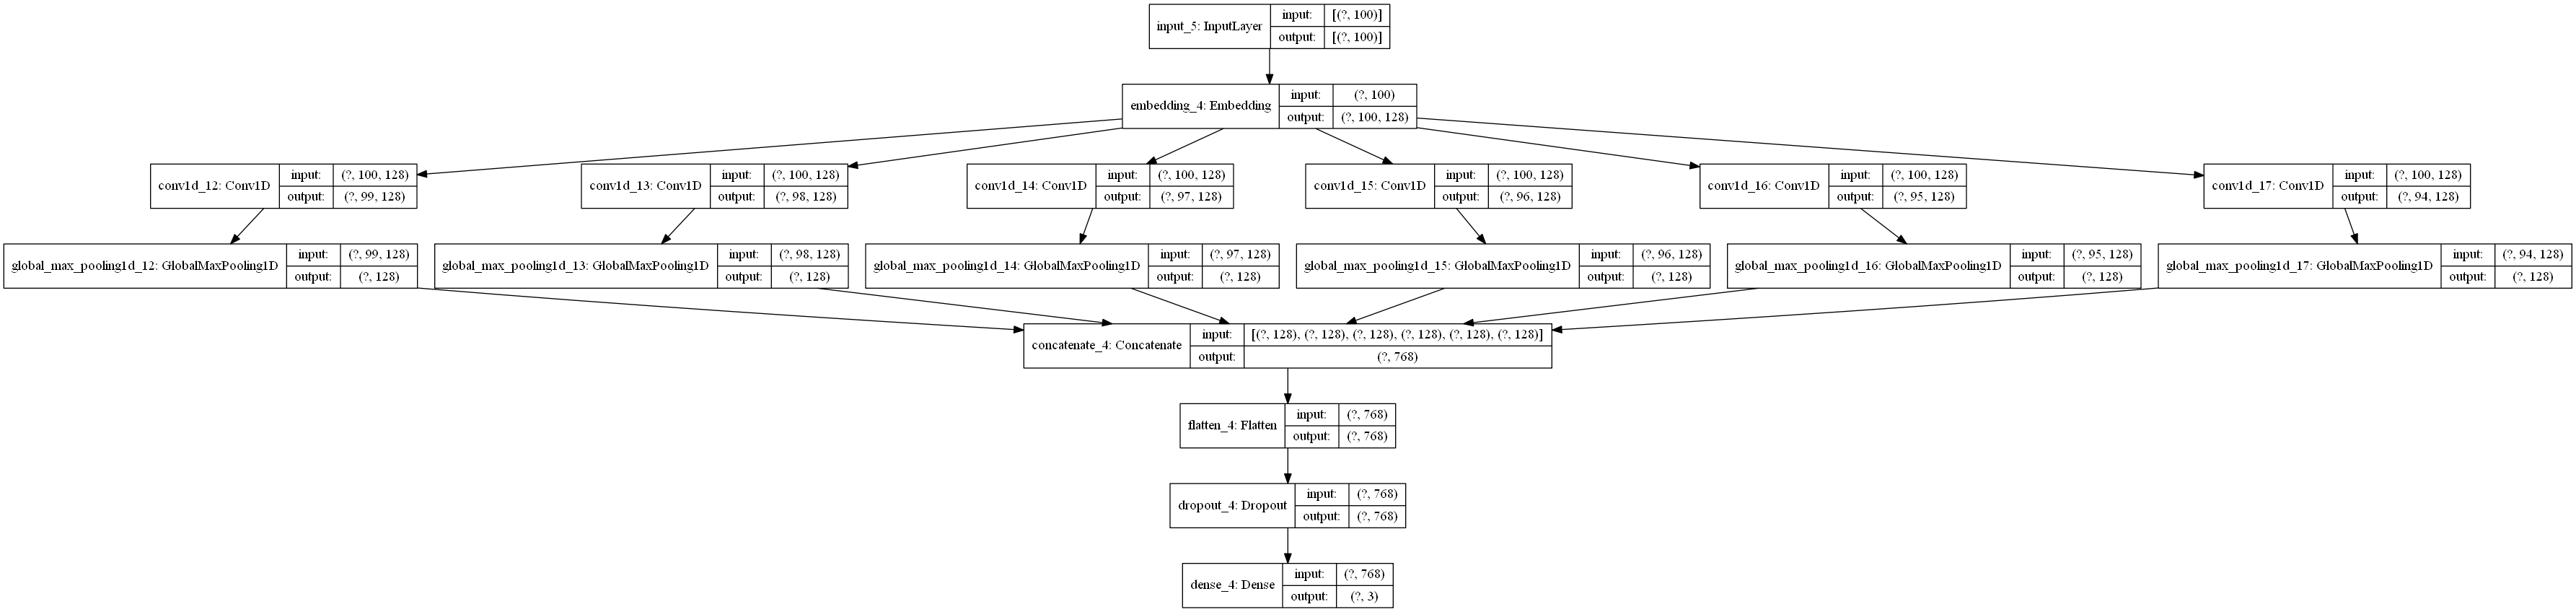

In [25]:
textcnn.plot_model()

In [20]:
model.fit()

define model...
compile model...
fit model...
Epoch 1/10
611/611 [==============================] - 7s 11ms/step - loss: 0.3426 - acc: 0.8736 - val_loss: 0.2828 - val_acc: 0.8888
Epoch 2/10
611/611 [==============================] - 6s 11ms/step - loss: 0.2605 - acc: 0.8979 - val_loss: 0.2736 - val_acc: 0.8939
Epoch 3/10
611/611 [==============================] - 6s 10ms/step - loss: 0.2245 - acc: 0.9128 - val_loss: 0.2814 - val_acc: 0.8965
Epoch 4/10
611/611 [==============================] - 6s 11ms/step - loss: 0.1953 - acc: 0.9265 - val_loss: 0.2945 - val_acc: 0.8928
Epoch 5/10
611/611 [==============================] - 7s 11ms/step - loss: 0.1668 - acc: 0.9384 - val_loss: 0.2910 - val_acc: 0.8967
Epoch 6/10
611/611 [==============================] - 6s 10ms/step - loss: 0.1416 - acc: 0.9456 - val_loss: 0.3432 - val_acc: 0.8969
Epoch 7/10
611/611 [==============================] - 6s 10ms/step - loss: 0.1214 - acc: 0.9563 - val_loss: 0.3480 - val_acc: 0.8929
Epoch 8/10
611/611 [===